In [2]:
# ==== 블록 0: 환경/설정/유틸 (최신) ====
import os, math, random, time
from pathlib import Path

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt

# ----- 프로젝트 경로 -----
PROJECT_ROOT = Path("/content/dcgan_plates512")
DATA_ROOT    = PROJECT_ROOT / "data"
IMG_DIR      = DATA_ROOT / "plates"        # 이미지 폴더 (블록1에서 확인/사용)
OUT_DIR      = PROJECT_ROOT / "outputs"
CKPT_DIR     = PROJECT_ROOT / "checkpoints"
for p in [PROJECT_ROOT, DATA_ROOT, IMG_DIR, OUT_DIR, CKPT_DIR]:
    p.mkdir(parents=True, exist_ok=True)

# ----- 디바이스/성능 옵션 -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True

def set_seed(seed: int = 2025):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(2025)

# ----- DCGAN 권장 초기화 -----
def weights_init_dcgan(m: nn.Module):
    cname = m.__class__.__name__
    if "Conv" in cname or "Linear" in cname:
        if getattr(m, "weight", None) is not None:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        if getattr(m, "bias", None) is not None and m.bias is not None:
            nn.init.zeros_(m.bias.data)
    elif "BatchNorm2d" in cname:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.zeros_(m.bias.data)

# ----- 시각화 유틸 (float16 안전 캐스팅) -----
def show_grid(tensors_or_list, title=None, nrow=8, save_path=None, dpi=120):
    """
    [-1,1] 범위 텐서를 그리드로 표시/저장. AMP로 인해 half가 들어와도 안전하게 float32로 변환.
    """
    if isinstance(tensors_or_list, list):
        tensors = torch.stack(tensors_or_list, dim=0)
    else:
        tensors = tensors_or_list
    grid = make_grid(tensors, nrow=nrow, normalize=True, value_range=(-1, 1))
    npimg = grid.detach().to(torch.float32).cpu().numpy()
    plt.figure(figsize=(nrow*1.2, 1.2*max(1, int(len(grid)/nrow))))
    plt.axis("off")
    if title: plt.title(title)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=dpi)
    plt.show()
    plt.close()

# ----- 환경 요약 출력 -----
def print_env():
    print(f"[Device] {device}")
    try:
        from torch.cuda import get_device_name
        if device.type == "cuda":
            print("[GPU]", get_device_name(0))
            print("[CUDA]", torch.version.cuda, "| [PyTorch]", torch.__version__)
    except Exception as e:
        pass
    print("[Paths]")
    print("  PROJECT_ROOT:", PROJECT_ROOT)
    print("  IMG_DIR     :", IMG_DIR)
    print("  OUT_DIR     :", OUT_DIR)
    print("  CKPT_DIR    :", CKPT_DIR)

print_env()

[Device] cuda
[GPU] Tesla T4
[CUDA] 12.6 | [PyTorch] 2.8.0+cu126
[Paths]
  PROJECT_ROOT: /content/dcgan_plates512
  IMG_DIR     : /content/dcgan_plates512/data/plates
  OUT_DIR     : /content/dcgan_plates512/outputs
  CKPT_DIR    : /content/dcgan_plates512/checkpoints


[해제] zip: /content/plate.zip
[완료] 1006개 이미지를 /content/dcgan_plates512/data/plates 로 이동
[데이터] 기본 폴더 사용: /content/dcgan_plates512/data/plates
[데이터] 이미지 수: 1006 @ 512x512
[로더] batch_size=4 num_workers=2 drop_last=True
[스모크] 첫 배치 shape: torch.Size([4, 3, 512, 512]), load_time=0.52s


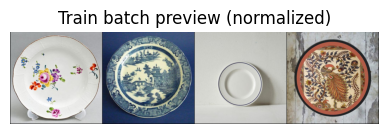

[저장] 미리보기: /content/dcgan_plates512/outputs/preview_batch.png


In [4]:
# ==== 블록 1-FIX: plate.zip 해제 + 이미지 이동 + 로더 재생성 ====
import zipfile, shutil, time
from pathlib import Path

# (A) IMG_DIR에 이미지가 있는지 점검
def _has_images(root: Path) -> bool:
    exts = {'.jpg','.jpeg','.png','.webp','.bmp','.tif','.tiff'}
    return any(p.suffix.lower() in exts for p in root.rglob('*'))

# (B) plate.zip을 찾아 해제하고 IMG_DIR로 이미지 모으기
def _extract_plate_zip():
    candidates = [
        Path('/content/plate.zip'),
        PROJECT_ROOT / 'plate.zip',
        Path('/content/drive/MyDrive/plate.zip'),
    ]
    zpath = next((p for p in candidates if p.exists()), None)
    if zpath is None:
        print('[경고] plate.zip을 찾지 못했습니다. /content로 업로드하거나 경로를 수정하세요.')
        return False

    tmp = DATA_ROOT / '_unzip_tmp'
    if tmp.exists():
        shutil.rmtree(tmp)
    tmp.mkdir(parents=True, exist_ok=True)

    print('[해제] zip:', zpath)
    with zipfile.ZipFile(zpath, 'r') as zf:
        zf.extractall(tmp)

    exts = {'.jpg','.jpeg','.png','.webp','.bmp','.tif','.tiff'}
    srcs = [p for p in tmp.rglob('*') if p.suffix.lower() in exts]
    if not srcs:
        print('[오류] 압축 내에서 이미지 파일을 찾지 못했습니다.')
        return False

    IMG_DIR.mkdir(parents=True, exist_ok=True)
    moved = 0
    for p in srcs:
        dst = IMG_DIR / p.name
        if dst.exists():
            stem, suf, k = dst.stem, dst.suffix, 1
            while (IMG_DIR / f'{stem}_{k}{suf}').exists():
                k += 1
            dst = IMG_DIR / f'{stem}_{k}{suf}'
        shutil.move(str(p), str(dst))
        moved += 1

    shutil.rmtree(tmp)
    print(f'[완료] {moved}개 이미지를 {IMG_DIR} 로 이동')
    return True

# (C) 필요 시 해제 수행
if not _has_images(IMG_DIR):
    ok = _extract_plate_zip()
    if not ok:
        raise FileNotFoundError('plate.zip 준비가 필요합니다. /content에 업로드 후 다시 실행하세요.')

# (D) 로더 재생성 + 스모크 테스트 + 미리보기 저장
dl_tr = make_loader(batch_size=4, num_workers=2, image_size=512, shuffle=True)
t0 = time.time()
first_batch = next(iter(dl_tr))
print(f'[스모크] 첫 배치 shape: {first_batch.shape}, load_time={time.time()-t0:.2f}s')

preview = first_batch[:8]
preview_path = OUT_DIR / 'preview_batch.png'
show_grid(preview, title='Train batch preview (normalized)', nrow=4, save_path=preview_path)
print('[저장] 미리보기:', preview_path)


In [21]:
# ==== 블록2U: DCGAN 업그레이드 모델 ====
import torch, torch.nn as nn, torch.nn.functional as F
from torch.nn.utils import spectral_norm as SN

# (A) Self-Attention (SAGAN 스타일, 64x64에서 1개만 사용)
class SelfAttn(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.q = nn.Conv2d(ch, ch//8, 1, bias=False)
        self.k = nn.Conv2d(ch, ch//8, 1, bias=False)
        self.v = nn.Conv2d(ch, ch,    1, bias=False)
        self.gamma = nn.Parameter(torch.zeros(1))
    def forward(self, x):
        b,c,h,w = x.shape
        q = self.q(x).reshape(b, -1, h*w)                    # (B, C/8, HW)
        k = self.k(x).reshape(b, -1, h*w)                    # (B, C/8, HW)
        attn = torch.softmax(torch.bmm(q.transpose(1,2), k), dim=-1)  # (B, HW, HW)
        v = self.v(x).reshape(b, c, h*w).transpose(1,2)      # (B, HW, C)
        y = torch.bmm(attn, v).transpose(1,2).reshape(b, c, h, w)
        return x + self.gamma * y

# (B) 업샘플 블록: NearestUpsample + Conv(3x3) -> 체크보드 감소
def up_block(cin, cout, bn=True):
    layers = [
        nn.Upsample(scale_factor=2, mode='nearest'),
        nn.Conv2d(cin, cout, 3, 1, 1, bias=False),
        nn.BatchNorm2d(cout) if bn else nn.Identity(),
        nn.ReLU(inplace=True),
    ]
    return nn.Sequential(*layers)

# (C) 다운 블록: SN(Conv) + LeakyReLU
def down_block(cin, cout, k=4, s=2, p=1):
    return nn.Sequential(
        SN(nn.Conv2d(cin, cout, k, s, p, bias=False)),
        nn.LeakyReLU(0.2, inplace=True),
    )

# (D) 가중치 초기화(DCGAN 표준)
def weights_init_dcgan(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight, 0.0, 0.02)
    elif isinstance(m, (nn.BatchNorm2d,)):
        nn.init.normal_(m.weight, 1.0, 0.02); nn.init.zeros_(m.bias)

# (E) Generator: z -> 4x4 시작, 4→8→...→512
class DCGANGenerator(nn.Module):
    def __init__(self, latent_dim=192, base_ch=64):  # 64*8=512 채널 시작
        super().__init__()
        ch = base_ch
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, ch*8*4*4, bias=False),
            nn.BatchNorm1d(ch*8*4*4),
            nn.ReLU(True),
        )
        self.net = nn.Sequential(
            nn.Unflatten(1, (ch*8, 4, 4)),      # 4x4
            up_block(ch*8, ch*8),               # 8x8
            up_block(ch*8, ch*4),               # 16x16
            up_block(ch*4, ch*2),               # 32x32
            up_block(ch*2, ch),                 # 64x64
            SelfAttn(ch),                       # ← 주의: 64x64에서 1개
            up_block(ch, ch//2),                # 128x128
            up_block(ch//2, ch//4),             # 256x256
            up_block(ch//4, ch//8, bn=False),   # 512x512
            nn.Conv2d(ch//8, 3, 3, 1, 1),
            nn.Tanh(),
        )
        self.apply(weights_init_dcgan)

    def forward(self, z):
        h = self.fc(z)
        return self.net(h)

# (F) Discriminator: SN + Hinge용 스칼라 출력
class DCGANDiscriminator(nn.Module):
    def __init__(self, base_ch=64):
        super().__init__()
        ch = base_ch
        # 입력 512x512
        self.net = nn.Sequential(
            down_block(3,     ch//8),   # 256
            down_block(ch//8, ch//4),   # 128
            down_block(ch//4, ch//2),   # 64
            SelfAttn(ch//2),            # ← 64x64에서 1개
            down_block(ch//2, ch),      # 32
            down_block(ch,     ch*2),   # 16
            down_block(ch*2,   ch*4),   # 8
            down_block(ch*4,   ch*8),   # 4
        )
        self.out = SN(nn.Linear(ch*8*4*4, 1))
        # Conv는 SN으로 안정화했으므로 BN은 사용 안 함

    def forward(self, x):
        h = self.net(x)
        h = h.reshape(x.size(0), -1)
        return self.out(h)              # (B, 1) — 로짓


In [24]:
# ==== 블록3U (수정): Hinge + Safe DiffAug + R1 + CosineLR + EMA ====
from torch.amp import autocast, GradScaler
from tqdm.auto import tqdm
import torch, torch.nn as nn, torch.nn.functional as F
import math, copy

# --- Safe DiffAug: 절대 in-place 금지 ---
def diff_augment_safe(x):
    y = x.clone()                             # ← 생성기 출력 보호
    B, C, H, W = y.shape
    # color (brightness/contrast) - out-of-place
    if torch.rand(1, device=y.device) < 0.8:
        y = y + (torch.rand(B, 1, 1, 1, device=y.device) - 0.5) * 0.1
        mean = y.mean(dim=1, keepdim=True)
        scale = 0.8 + torch.rand(B, 1, 1, 1, device=y.device) * 0.4
        y = (y - mean) * scale + mean
        y = y.clamp(-1, 1)
    # translation (pad 후 슬라이싱) - out-of-place
    if torch.rand(1, device=y.device) < 0.8:
        shift = int(0.05 * W)
        if shift > 0:
            y_pad = F.pad(y, (shift, shift, shift, shift), mode="reflect")
            tx = torch.randint(-shift, shift + 1, (B,), device=y.device)
            ty = torch.randint(-shift, shift + 1, (B,), device=y.device)
            ys = []
            for i in range(B):
                xs, ys_i = shift + tx[i].item(), shift + ty[i].item()
                ys.append(y_pad[i:i+1, :, ys_i:ys_i+H, xs:xs+W])
            y = torch.cat(ys, dim=0)
    # cutout (mask 곱) - out-of-place
    if torch.rand(1, device=y.device) < 0.5:
        ch, cw = max(1, int(H*0.20)), max(1, int(W*0.20))
        cy = torch.randint(0, H - ch + 1, (B,), device=y.device)
        cx = torch.randint(0, W - cw + 1, (B,), device=y.device)
        mask = torch.ones_like(y)
        for i in range(B):
            mask[i, :, cy[i]:cy[i]+ch, cx[i]:cx[i]+cw] = 0
        y = y * mask
    return y.clamp(-1, 1)

# --- EMA(버퍼 동기화) ---
class _EMA:
    def __init__(self, model, decay=0.999):
        self.m = model
        self.ema = copy.deepcopy(model).eval().to(next(model.parameters()).device)
        for p in self.ema.parameters(): p.requires_grad_(False)
        self.decay = decay
    @torch.no_grad()
    def update(self):
        for pe, p in zip(self.ema.parameters(), self.m.parameters()):
            pe.data.mul_(self.decay).add_(p.data, alpha=1.0 - self.decay)
        src_bufs = dict(self.m.named_buffers())
        for n, b in self.ema.named_buffers():
            if n in src_bufs: b.copy_(src_bufs[n])

def train_dcgan_hinge(
    epochs=200,
    latent_dim=192,
    batch_size=4,
    lr_g=2e-4, lr_d=2e-4,
    beta1=0.0, beta2=0.9,
    r1_gamma=1.0, r1_every=16,
    use_diffaug=True,
    ema_decay_start=0.999, ema_decay_late=0.9995, ema_switch_ep=200,
    warmup_ema_epochs=5,
    sample_every=1,
    resume_ckpt: str | None = None,
):
    assert 'DCGANGenerator' in globals() and 'DCGANDiscriminator' in globals()
    dl = make_loader(batch_size=batch_size, num_workers=0, image_size=512, shuffle=True) \
         if 'make_loader' in globals() else dl_tr

    G = DCGANGenerator(latent_dim=latent_dim).to(device)
    D = DCGANDiscriminator().to(device)
    opt_g = torch.optim.Adam(G.parameters(), lr=lr_g, betas=(beta1, beta2))
    opt_d = torch.optim.Adam(D.parameters(), lr=lr_d, betas=(beta1, beta2))
    sg, sd = GradScaler('cuda'), GradScaler('cuda')

    sch_g = torch.optim.lr_scheduler.CosineAnnealingLR(opt_g, T_max=epochs, eta_min=lr_g*0.05)
    sch_d = torch.optim.lr_scheduler.CosineAnnealingLR(opt_d, T_max=epochs, eta_min=lr_d*0.05)

    ema = _EMA(G, decay=ema_decay_start)
    fixed_z = torch.randn(64, latent_dim, device=device)

    start_epoch = 1
    if resume_ckpt:
        ckpt = torch.load(resume_ckpt, map_location=device)
        G.load_state_dict(ckpt['gen'], strict=False)
        D.load_state_dict(ckpt['dis'], strict=False)
        opt_g.load_state_dict(ckpt['opt_g']); opt_d.load_state_dict(ckpt['opt_d'])
        if ckpt.get('ema') is not None: ema.ema.load_state_dict(ckpt['ema'], strict=False)
        start_epoch = ckpt['epoch'] + 1
        print(f"[재개] epoch={start_epoch}")

    def _hinge_d(d_real, d_fake): return (F.relu(1 - d_real).mean() + F.relu(1 + d_fake).mean())
    def _hinge_g(d_fake):         return (-d_fake).mean()

    for epoch in range(start_epoch, epochs+1):
        ema.decay = ema_decay_start if epoch < ema_switch_ep else ema_decay_late
        G.train(); D.train()
        g_sum = d_sum = 0.0; steps = 0
        pbar = tqdm(dl, desc=f"[E{epoch:03d}] train", leave=False)

        for i, real in enumerate(pbar, 1):
            real = real.to(device, non_blocking=True)

            # ----- D step -----
            opt_d.zero_grad(set_to_none=True)
            z = torch.randn(real.size(0), latent_dim, device=device)
            with autocast('cuda'):
                fake_det = G(z).detach()
                x_real = diff_augment_safe(real) if use_diffaug else real
                x_fake = diff_augment_safe(fake_det) if use_diffaug else fake_det
                d_real = D(x_real).view(-1,1)
                d_fake = D(x_fake).view(-1,1)
                d_loss = _hinge_d(d_real, d_fake)

            if r1_gamma > 0 and (i % r1_every == 0):
                real_r = real.detach().requires_grad_(True)
                d_real_r = D(real_r).sum()
                grad = torch.autograd.grad(d_real_r, real_r, create_graph=True)[0]
                r1 = grad.square().reshape(grad.size(0), -1).sum(dim=1).mean()
                d_loss = d_loss + (r1_gamma * 0.5) * r1

            sd.scale(d_loss).backward()
            sd.step(opt_d); sd.update()

            # ----- G step -----
            opt_g.zero_grad(set_to_none=True)
            z = torch.randn(real.size(0), latent_dim, device=device)
            with autocast('cuda'):
                fake = G(z)
                x_fake = diff_augment_safe(fake) if use_diffaug else fake  # ← 안전
                g_loss = _hinge_g(D(x_fake))
            sg.scale(g_loss).backward()
            sg.step(opt_g); sg.update()

            ema.update()
            g_sum += g_loss.item(); d_sum += d_loss.item(); steps += 1
            pbar.set_postfix({"g": f"{g_loss.item():.3f}", "d": f"{d_loss.item():.3f}"})

        sch_g.step(); sch_d.step()
        print(f"[E{epoch:03d} END] g={g_sum/steps:.4f} d={d_sum/steps:.4f}")

        if epoch % sample_every == 0:
            with torch.no_grad(), autocast('cuda'):
                model_for_sample = G if epoch <= warmup_ema_epochs else ema.ema
                img = model_for_sample(fixed_z).clamp(-1, 1).to(torch.float32)
            save_path = OUT_DIR / f"samples_e{epoch:03d}.png"
            show_grid(img, title=f"Epoch {epoch} ({'G' if epoch <= warmup_ema_epochs else 'EMA'})",
                      nrow=8, save_path=save_path)
            print("[저장]", save_path)

        ckpt_path = CKPT_DIR / f"dcgan_hinge_e{epoch:03d}.pt"
        torch.save({
            "epoch": epoch,
            "gen": G.state_dict(), "dis": D.state_dict(),
            "opt_g": opt_g.state_dict(), "opt_d": opt_d.state_dict(),
            "latent_dim": latent_dim, "ema": ema.ema.state_dict()
        }, ckpt_path)

    print("[완료] 학습 종료")
    return str(ckpt_path)


In [7]:
# ==== 블록 4: 샘플링/인터폴레이션 유틸 (EMA 우선) ====
import torch
from pathlib import Path

@torch.no_grad()
def _load_generator_from_ckpt(ckpt_path: str):
    """
    체크포인트에서 생성기 가중치를 로드.
    - ema 가중치가 있으면 그것을 우선 사용
    - 없으면 gen 가중치 사용
    """
    ckpt = torch.load(ckpt_path, map_location=device)
    latent_dim = ckpt.get("latent_dim", 128)
    G = DCGANGenerator(latent_dim=latent_dim).to(device).eval()
    if ckpt.get("ema") is not None:
        print("[로드] EMA 가중치 사용")
        G.load_state_dict(ckpt["ema"], strict=False)
    else:
        print("[로드] gen 가중치 사용")
        G.load_state_dict(ckpt["gen"], strict=False)
    return G, latent_dim

@torch.no_grad()
def generate_samples(ckpt_path: str, n: int = 32, nrow: int = 8, save_name: str = "final_samples.png"):
    G, latent_dim = _load_generator_from_ckpt(ckpt_path)
    z = torch.randn(n, latent_dim, device=device)
    fake = G(z).clamp(-1, 1).to(torch.float32)
    out_path = OUT_DIR / save_name
    show_grid(fake, title="Generated Samples (EMA)", nrow=nrow, save_path=out_path)
    print("[저장]", out_path)
    return out_path

@torch.no_grad()
def interpolate(ckpt_path: str, steps: int = 8, save_name: str = "interpolation.png"):
    G, latent_dim = _load_generator_from_ckpt(ckpt_path)
    z0 = torch.randn(1, latent_dim, device=device)
    z1 = torch.randn(1, latent_dim, device=device)
    zs = torch.cat([(1-t)*z0 + t*z1 for t in torch.linspace(0, 1, steps, device=device)], dim=0)
    fake = G(zs).clamp(-1, 1).to(torch.float32)
    out_path = OUT_DIR / save_name
    show_grid(fake, title="Interpolation (z0 → z1)", nrow=steps, save_path=out_path)
    print("[저장]", out_path)
    return out_path

In [25]:
# ==== 블록 5: 러너 (학습 시작 & 시각화 호출) ====

def run_training_and_preview(epochs=150, latent_dim=192, batch_size=4, resume_ckpt=None):
    last_ckpt = train_dcgan_hinge(
        epochs=epochs, latent_dim=latent_dim, batch_size=batch_size,
        resume_ckpt=resume_ckpt, sample_every=1, warmup_ema_epochs=10
    )
    _ = generate_samples(last_ckpt, n=32, nrow=8)   # 기존 블록4 그대로 사용 가능
    _ = interpolate(last_ckpt, steps=8)
    return last_ckpt

# 예시
last_ckpt = run_training_and_preview(epochs=150, latent_dim=192, batch_size=4)

# --- 실행 프리셋 ---

# (1) 빠른 스모크(정상 동작 확인용)
# last_ckpt = run_training_and_preview(epochs=3, latent_dim=192, batch_size=2, resume_ckpt=None)

# (2) 권장 본 학습(품질 우선)
# last_ckpt = run_training_and_preview(epochs=100, latent_dim=192, batch_size=4, resume_ckpt=None)
# print("[완료] 최종 체크포인트:", last_ckpt)


Output hidden; open in https://colab.research.google.com to view.

In [15]:
# ==== 블록 6: 대량 생성(EMA 우선) + 구글 드라이브 저장 ====
import os, time, json, math, shutil
from datetime import datetime
from pathlib import Path
import torch
from torchvision.utils import save_image

# (A) 드라이브 마운트 보조
def ensure_drive_mounted() -> bool:
    try:
        from google.colab import drive  # noqa
    except Exception:
        print("[정보] Colab 환경이 아닙니다. 로컬 경로로 저장합니다.")
        return False
    if not os.path.ismount("/content/drive"):
        from google.colab import drive
        drive.mount("/content/drive")
    return True

# (B) 생성기 로드(EMA 우선)
@torch.no_grad()
def load_G(ckpt_path: str | None = None, use_ema: bool = True):
    if ckpt_path is None:
        cks = sorted(Path(CKPT_DIR).glob("dcgan_max_e*.pt"))
        assert cks, f"체크포인트가 없습니다: {CKPT_DIR}"
        ckpt_path = str(cks[-1])
    ckpt = torch.load(ckpt_path, map_location=device)
    latent_dim = ckpt.get("latent_dim", 128)

    G = DCGANGenerator(latent_dim=latent_dim).to(device).eval()
    if use_ema and ckpt.get("ema") is not None:
        G.load_state_dict(ckpt["ema"], strict=False)
        src = "EMA"
    else:
        G.load_state_dict(ckpt["gen"], strict=False)
        src = "G"
    print(f"[로드] {src} 가중치 사용 | ckpt={ckpt_path}")
    return G, latent_dim, ckpt_path, src

# (C) 대량 생성 본체: 드라이브 경로에 저장
@torch.no_grad()
def generate_many_drive(
    drive_out_dir: str | Path | None = None,   # 저장할 드라이브 경로
    total: int = 50,                           # 생성 개수(요청: 50장)
    batch: int = 16,                           # 배치 크기(메모리에 맞게 조정)
    truncation: float = 0.9,                   # z 스케일(0.7~0.95 품질↑ / 1.0 다양성↑)
    use_ema: bool = True,                      # EMA 가중치 사용 여부
    ckpt_path: str | None = None,              # 특정 ckpt를 쓰고 싶으면 지정
    prefix: str = "plate",                     # 파일명 접두사
    seed: int | None = None,                   # 재현성 필요 시 고정
    make_zip: bool = True                      # ZIP으로도 묶기
):
    # 드라이브 마운트 및 저장 경로 결정
    mounted = ensure_drive_mounted()
    if drive_out_dir is None:
        base = Path("/content/drive/MyDrive/dcgan_plates512/generated") if mounted else OUT_DIR / "generated"
        ts = datetime.now().strftime("%Y%m%d_%H%M%S")
        drive_out_dir = base / f"gen_{ts}"
    drive_out_dir = Path(drive_out_dir)
    drive_out_dir.mkdir(parents=True, exist_ok=True)

    # 모델 로드
    G, zdim, used_ckpt, weight_src = load_G(ckpt_path, use_ema=use_ema)

    # 시드 고정(옵션)
    if seed is not None:
        torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

    # 생성 루프
    print(f"[생성] 저장경로={drive_out_dir}\n        total={total} batch={batch} trunc={truncation} use_ema={use_ema}")
    t0 = time.time(); saved = 0; idx = 0
    while saved < total:
        b = min(batch, total - saved)
        z = torch.randn(b, zdim, device=device) * truncation
        with torch.amp.autocast('cuda'):
            imgs = G(z).clamp(-1, 1)  # [-1,1]

        for i in range(b):
            out_path = drive_out_dir / f"{prefix}_{idx:05d}.png"
            save_image(
                imgs[i].to(torch.float32),
                out_path,
                normalize=True, value_range=(-1, 1)
            )
            idx += 1
        saved += b

    # 메타데이터 기록
    meta = {
        "total": total, "batch": batch, "truncation": truncation,
        "use_ema": use_ema, "ckpt": used_ckpt, "weight_src": weight_src,
        "latent_dim": zdim, "prefix": prefix, "device": str(device),
        "timestamp": datetime.now().isoformat()
    }
    with open(drive_out_dir / "params.json", "w") as f:
        json.dump(meta, f, indent=2, ensure_ascii=False)

    zip_path = None
    if make_zip:
        zip_path = shutil.make_archive(str(drive_out_dir), "zip", drive_out_dir)
    print(f"[완료] {saved}장 저장 | 폴더={drive_out_dir} | ZIP={zip_path} | {time.time()-t0:.1f}s")
    return str(drive_out_dir), zip_path

# === 사용 예시 ===
# 원하는 드라이브 경로에 50장 생성(EMA, truncation=0.9)
# out_dir, zip_path = generate_many_drive(
#     drive_out_dir="/content/drive/MyDrive/my_plates/run01",
#     total=50, batch=16, truncation=0.9, use_ema=True, prefix="plate"
# )
# print(out_dir, zip_path)


In [16]:
# === 사용 예시 ===
# 원하는 드라이브 경로에 50장 생성(EMA, truncation=0.9)
out_dir, zip_path = generate_many_drive(
    drive_out_dir="/content/drive/MyDrive/my_plates/run02",
    total=50, batch=16, truncation=0.9, use_ema=True, prefix="plate"
)
print(out_dir, zip_path)

[로드] EMA 가중치 사용 | ckpt=/content/dcgan_plates512/checkpoints/dcgan_max_e100.pt
[생성] 저장경로=/content/drive/MyDrive/my_plates/run01
        total=50 batch=16 trunc=0.9 use_ema=True
[완료] 50장 저장 | 폴더=/content/drive/MyDrive/my_plates/run01 | ZIP=/content/drive/MyDrive/my_plates/run01.zip | 6.2s
/content/drive/MyDrive/my_plates/run01 /content/drive/MyDrive/my_plates/run01.zip


In [ ]:
out_dir, zip_path = generate_many_drive(
    drive_out_dir="/content/drive/MyDrive/plates_generated/run02",
    total=50, truncation=0.9, use_ema=True,
    ckpt_path="/content/dcgan_plates512/checkpoints/dcgan_max_e149.pt"  # 예시
)

In [19]:
# ==== 블록 7: 데이터셋 이미지 ↔ DCGAN 재생성(Inversion) 비교 ====
import math, time
from pathlib import Path
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import models
from torchvision.utils import save_image
import matplotlib.pyplot as plt

# (A) 보조: [-1,1] <-> [0,1]
def to01(x):  return (x.clamp(-1,1) + 1.0) * 0.5
def to11(x01): return x01 * 2.0 - 1.0

# (B) 데이터셋에서 한 장 로드 (증강 OFF, 512×512, [-1,1])
def load_real_from_dataset(index: int = 0):
    ds = ImageFolder512(choose_data_dir(), image_size=512, augment=False)
    assert 0 <= index < len(ds), f"index 범위: [0, {len(ds)-1}]"
    x = ds[index]  # (3,512,512) in [-1,1]
    return x.unsqueeze(0).to(device)  # (1,3,512,512)

# (C) VGG 기반 Perceptual feature 추출기 (고정)
class VGGFeature(nn.Module):
    def __init__(self, layers=(8, 15)):  # relu2_2, relu3_3 근처
        super().__init__()
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_FEATURES).features.eval()
        for p in vgg.parameters(): p.requires_grad_(False)
        self.backbone = vgg.to(device)
        self.layers = set(layers)
    def forward(self, x01):  # x01: [0,1]
        # ImageNet 정규화
        mean = torch.tensor([0.485, 0.456, 0.406], device=x01.device).view(1,3,1,1)
        std  = torch.tensor([0.229, 0.224, 0.225], device=x01.device).view(1,3,1,1)
        h = (x01 - mean) / std
        feats = []
        for i, m in enumerate(self.backbone):
            h = m(h)
            if i in self.layers: feats.append(h)
        return feats

# (D) 한 장 Inversion (z 최적화)
@torch.no_grad()
def _freeze(model: torch.nn.Module):
    for p in model.parameters(): p.requires_grad_(False)
    model.eval(); return model

def invert_one_image(
    real_x: torch.Tensor,
    steps: int = 400,
    lr: float = 0.05,
    w_l1: float = 1.0,
    w_perc: float = 0.1,
    z_reg: float = 1e-4,
    use_ema: bool = True,
    ckpt_path: str | None = None,
    verbose_every: int = 50,
):
    """
    real_x: (1,3,512,512) in [-1,1]
    반환: z*, fake_x, 로그(dict)
    """
    # 생성기 로드 (EMA 우선)
    G, zdim, used_ckpt, src = load_G(ckpt_path, use_ema=use_ema)
    _freeze(G)

    # Perceptual loss 준비
    vgg = VGGFeature().eval()

    # z 초기화 및 최적화 설정
    z = torch.randn(1, zdim, device=device, requires_grad=True)
    opt = torch.optim.Adam([z], lr=lr)

    real01 = to01(real_x)
    log = {}
    t0 = time.time()
    for t in range(1, steps+1):
        opt.zero_grad(set_to_none=True)
        fake = G(z)
        fake01 = to01(fake)

        # 손실: L1 + Perceptual(VGG) + z 정규화
        l1 = F.l1_loss(fake01, real01)
        f_fake = vgg(fake01)
        f_real = vgg(real01)
        perc = sum(F.l1_loss(a, b) for a, b in zip(f_fake, f_real))
        reg = (z*z).mean()
        loss = w_l1*l1 + w_perc*perc + z_reg*reg

        loss.backward()
        opt.step()

        if verbose_every and (t % verbose_every == 0 or t == 1 or t == steps):
            with torch.no_grad():
                mse = F.mse_loss(fake01, real01).item()
                psnr = 10.0 * math.log10(1.0 / (mse + 1e-12))
                print(f"[invert t={t:04d}] loss={loss.item():.4f} | L1={l1.item():.4f} "
                      f"| P={perc.item():.4f} | PSNR={psnr:.2f}dB")
    log["elapsed_sec"] = time.time()-t0
    log["ckpt"] = used_ckpt; log["weight_src"] = src
    return z.detach(), fake.detach(), log

# (E) 시각화 & 저장
def compare_real_vs_recon(
    index: int = 0,
    steps: int = 400,
    use_ema: bool = True,
    save_name: str | None = None,
    ckpt_path: str | None = None
):
    real = load_real_from_dataset(index)          # (1,3,512,512) in [-1,1]
    z_star, fake, meta = invert_one_image(real, steps=steps, use_ema=use_ema, ckpt_path=ckpt_path)

    real01 = to01(real)[0].cpu()
    fake01 = to01(fake)[0].cpu()
    diff   = (real01 - fake01).abs()

    # PSNR/L1 표시
    mse = F.mse_loss(fake01, real01).item()
    psnr = 10.0 * math.log10(1.0 / (mse + 1e-12))
    l1   = F.l1_loss(fake01, real01).item()

    # Matplotlib 비교 그림
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for ax in axes: ax.axis("off")
    axes[0].set_title("Real")
    axes[0].imshow(np.transpose(real01.numpy(), (1,2,0)))
    axes[1].set_title("Reconstruction")
    axes[1].imshow(np.transpose(fake01.numpy(), (1,2,0)))
    axes[2].set_title("Abs Diff")
    axes[2].imshow(np.transpose(diff.numpy(), (1,2,0)))

    if save_name is None:
        save_name = f"compare_inversion_idx{index:04d}.png"
    out_path = OUT_DIR / save_name
    plt.tight_layout()
    plt.savefig(out_path, bbox_inches="tight", dpi=150)
    plt.show(); plt.close()

    # 개별 PNG도 옵션으로 저장
    save_image(to11(real01.unsqueeze(0)), OUT_DIR / f"real_{index:04d}.png",
               normalize=True, value_range=(-1,1))
    save_image(to11(fake01.unsqueeze(0)), OUT_DIR / f"recon_{index:04d}.png",
               normalize=True, value_range=(-1,1))

    print(f"[저장] {out_path} | PSNR={psnr:.2f}dB, L1={l1:.4f}, took={meta['elapsed_sec']:.1f}s")
    return dict(psnr=psnr, l1=l1, z=z_star, recon=fake, real=real, meta=meta)

# === 사용 예시 ===
# 데이터셋 0번 이미지를 400스텝으로 재생성(EMA 사용) 후 비교 저장
# result = compare_real_vs_recon(index=0, steps=400, use_ema=True)
# 다른 이미지:
# result = compare_real_vs_recon(index=123, steps=400, use_ema=True)


In [ ]:
# === 사용 예시 ===
# 데이터셋 0번 이미지를 400스텝으로 재생성(EMA 사용) 후 비교 저장
result = compare_real_vs_recon(index=10, steps=800, use_ema=True)
# 다른 이미지:
result = compare_real_vs_recon(index=123, steps=800, use_ema=True)
result = compare_real_vs_recon(index=234, steps=800, use_ema=True)

In [ ]:
# ==== 블록 7+ : 개선 인버전 (LPIPS + FFT + 원형마스크 + 멀티스타트) ====
# 1) 의존성
!pip -q install lpips
import lpips, math, time, numpy as np, torch, torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.utils import save_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 유틸: [-1,1] <-> [0,1]
def to01(x):  return (x.clamp(-1,1) + 1.0) * 0.5
def to11(x01): return x01 * 2.0 - 1.0

# 소프트 원형 마스크(접시 중심 가중)
def soft_circ_mask(h=512, w=512, radius=0.92, sharp=20.0, device=device):
    yy, xx = torch.meshgrid(
        torch.linspace(-1, 1, h, device=device),
        torch.linspace(-1, 1, w, device=device),
        indexing='ij'
    )
    rr = torch.sqrt(xx**2 + yy**2)
    # 바깥은 0, 안쪽은 1로 부드럽게
    m = torch.sigmoid((radius - rr) * sharp)
    return m  # (H,W)

# FFT 저주파 일치 손실
def fft_mag_l1(a, b):
    A = torch.fft.rfftn(a, dim=(2,3))
    B = torch.fft.rfftn(b, dim=(2,3))
    return F.l1_loss(torch.abs(A), torch.abs(B))

# LPIPS 준비(VGG 백본)
lpips_fn = lpips.LPIPS(net='vgg').to(device).eval()

# 데이터셋에서 한 장 로드(증강 OFF)
def load_real_from_dataset(index: int = 0):
    ds = ImageFolder512(choose_data_dir(), image_size=512, augment=False)
    x = ds[index].unsqueeze(0).to(device)  # [-1,1], (1,3,512,512)
    return x

@torch.no_grad()
def _freeze(m: torch.nn.Module):
    for p in m.parameters(): p.requires_grad_(False)
    m.eval(); return m

def invert_one_image_pro(
    real_x,                      # (1,3,512,512) in [-1,1]
    steps=800,                   # 더 오래 돌릴수록 정밀
    lr=0.08,
    n_starts=6,                  # 멀티스타트
    use_ema=True,
    ckpt_path=None,
    w_l1=1.0, w_perc=0.5, w_fft=0.2, w_mask=1.0, z_reg=1e-4,
    radius=0.92, sharp=20.0,     # 원형 마스크 설정
    verbose_every=100
):
    # 생성기 로드
    G, zdim, used_ckpt, src = load_G(ckpt_path, use_ema=use_ema)
    _freeze(G)

    # 마스크
    M = soft_circ_mask(real_x.shape[-2], real_x.shape[-1], radius, sharp).view(1,1,*real_x.shape[-2:])  # (1,1,H,W)

    # 타깃을 [0,1]과 [-1,1] 둘 다 준비
    real01 = to01(real_x); real11 = real_x

    best = {"loss": 1e9, "z": None, "fake": None}
    for s in range(n_starts):
        z = torch.randn(1, zdim, device=device, requires_grad=True)
        opt = torch.optim.Adam([z], lr=lr)
        # 코사인 LR 스케줄
        sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=steps, eta_min=lr*0.05)

        t0 = time.time()
        for t in range(1, steps+1):
            opt.zero_grad(set_to_none=True)
            fake = G(z)
            fake01 = to01(fake)

            # 1) 마스크 L1(공간)
            l1 = (M * (fake01 - real01).abs()).mean()

            # 2) LPIPS(지각) — 입력은 [-1,1]
            perc = lpips_fn(fake, real11).mean()

            # 3) FFT(저주파 색/형태)
            fftl = fft_mag_l1(fake01, real01)

            # 4) z 정규화
            reg = (z*z).mean()

            loss = w_mask*(w_l1*l1 + w_perc*perc + w_fft*fftl) + z_reg*reg
            loss.backward(); opt.step(); sched.step()

            if verbose_every and (t % verbose_every == 0 or t == steps):
                print(f"[start {s+1}/{n_starts} | t={t:04d}] "
                      f"loss={loss.item():.4f} | L1={l1.item():.4f} | LPIPS={perc.item():.4f} | FFT={fftl.item():.4f}")

        with torch.no_grad():
            final_fake = G(z).detach()
            # 선택 기준: 마스크 L1 + LPIPS
            l1_final = (M * (to01(final_fake) - real01).abs()).mean().item()
            lp_final = lpips_fn(final_fake, real11).mean().item()
            score = l1_final + 0.5*lp_final   # 가중합
            if score < best["loss"]:
                best.update({"loss": score, "z": z.detach(), "fake": final_fake.detach()})

    print("[완료] best score:", best["loss"], "| ckpt:", used_ckpt, "| src:", src)
    return best["z"], best["fake"]

def compare_real_vs_recon_pro(index=0, steps=800, n_starts=6, use_ema=True, ckpt_path=None, save_name=None):
    real = load_real_from_dataset(index)          # [-1,1]
    z_star, fake = invert_one_image_pro(real, steps=steps, n_starts=n_starts, use_ema=use_ema, ckpt_path=ckpt_path)
    real01, fake01 = to01(real)[0].cpu(), to01(fake)[0].cpu()
    diff = (real01 - fake01).abs()

    # 수치 지표
    mse = F.mse_loss(fake01, real01).item()
    psnr = 10.0 * math.log10(1.0 / (mse + 1e-12))

    # 시각화
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for ax in axes: ax.axis("off")
    axes[0].set_title("Real");           axes[0].imshow(np.transpose(real01.numpy(), (1,2,0)))
    axes[1].set_title("Reconstruction"); axes[1].imshow(np.transpose(fake01.numpy(), (1,2,0)))
    axes[2].set_title("Abs Diff");       axes[2].imshow(np.transpose(diff.numpy(), (1,2,0)))
    if save_name is None:
        save_name = f"compare_inversion_pro_idx{index:04d}.png"
    out_path = OUT_DIR / save_name
    plt.tight_layout(); plt.savefig(out_path, bbox_inches="tight", dpi=150); plt.show(); plt.close()
    print("[저장]", out_path, f"| PSNR={psnr:.2f}dB")
    return {"z": z_star, "fake": fake, "real": real}

# ==== 사용 예시 ====
# 더 강한 인버전으로 다시 비교 (LPIPS+FFT+마스크, 멀티스타트 6, 800스텝)
# _ = compare_real_vs_recon_pro(index=0, steps=800, n_starts=6, use_ema=True)
